# =========================
# Load libraries
# =========================

In [45]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras import models
from keras import layers
import keras_metrics as km
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from src.data.preprocess_word_embeddings import init_embeddings

# =========================
# Load data
# =========================

In [46]:
# Load gold data
data = pd.read_csv("../data/processed/stanford.csv")

train_data, test_data, train_labels, test_labels = train_test_split(
    data["text"], data["label"], test_size=0.2
)

# =========================
# Prepare data
# =========================

In [47]:
# Create unique index for every word and fit to training data
tokenizer = Tokenizer(num_words = 10000)
tokenizer.fit_on_texts(train_data)

# Turn each tweet into a sequence of integers of equal length
sequences = tokenizer.texts_to_sequences(train_data)
train_corpus_embeddings = pad_sequences(sequences)

# Print the number of unique words found in the data set (not the limit placed
# on the tokenizer), use this as feedback to the num_words arg of Tokenizer().
print('Found %d unique words.' % len(tokenizer.word_index))

Found 54323 unique words.


# =========================
# Split data
# =========================

In [48]:
# Randomly shuffle data
indices = np.arange(train_data.shape[0])
np.random.shuffle(indices)
train_corpus_embeddings = train_corpus_embeddings[indices]
train_labels = train_labels.values[indices]

# Split into training and validation data (approximately 80:20)
x_train = train_corpus_embeddings[:10410]
y_train = train_labels[:10410]
x_val   = train_corpus_embeddings[10410:]
y_val   = train_labels[10410:]

# =========================
# Parse GloVe word-embeddings
# =========================

# You need to download the pre-trained word vectors from:
# https://nlp.stanford.edu/projects/glove/

In [49]:
word_embedding_matrix = init_embeddings(tokenizer.word_index, 10000, 200, "/home/tcake/Downloads/glove.twitter.27B/glove.twitter.27B.200d.txt")

# =========================
# Build model
# =========================

In [50]:
# Add Embedding layer
# The final sigmoid layer outputs probability values between [0, 1]
model = models.Sequential()
model.add(layers.Embedding(10001, 200, input_length = train_corpus_embeddings.shape[1]))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

# =========================
# Load GloVe emdebbings
# =========================

In [51]:
# Load pretrained word embeddings
model.layers[0].set_weights([word_embedding_matrix])
model.layers[0].trainable = False

# =========================
# Train model
# =========================

Train on 10410 samples, validate on 14401 samples
Epoch 1/20
10410/10410 [==============================] - 6s 615us/step - loss: 0.5398 - precision: 0.7456 - recall: 0.8158 - val_loss: 0.5344 - val_precision: 0.7205 - val_recall: 0.8623
Epoch 2/20
10410/10410 [==============================] - 6s 590us/step - loss: 0.3921 - precision: 0.8516 - recall: 0.8418 - val_loss: 0.5646 - val_precision: 0.7177 - val_recall: 0.8690
Epoch 3/20
10410/10410 [==============================] - 6s 609us/step - loss: 0.2733 - precision: 0.9083 - recall: 0.9045 - val_loss: 0.6095 - val_precision: 0.7629 - val_recall: 0.7917
Epoch 4/20
10410/10410 [==============================] - 6s 585us/step - loss: 0.1876 - precision: 0.9418 - recall: 0.9401 - val_loss: 0.7449 - val_precision: 0.7613 - val_recall: 0.7942
Epoch 5/20
10410/10410 [==============================] - 6s 563us/step - loss: 0.1293 - precision: 0.9635 - recall: 0.9610 - val_loss: 0.8723 - val_precision: 0.8171 - val_recall: 0.6835
Epoch 6/20

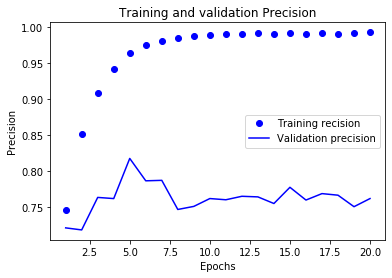

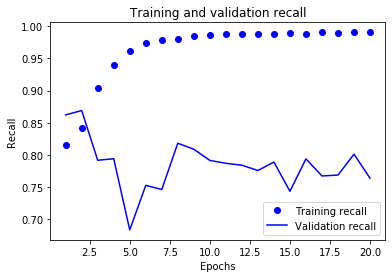

In [52]:
# As the model outputs probabilities, binary crossentropy is the best loss
# metric as it measures the distance between probability distributions
model.compile(optimizer = 'rmsprop',
              loss = 'binary_crossentropy',
              metrics=[km.binary_precision(), km.binary_recall()])

history = model.fit(x_train,
                    y_train,
                    epochs = 20,
                    batch_size = 32,
                    validation_data = (x_val, y_val))

# Prep history dictionary
precision = history.history['precision']
val_precision = history.history['val_precision']
recall = history.history['recall']
val_recall = history.history['val_recall']
epochs = range(1, len(precision) + 1)

# Plot the training and validation precision
plt.plot(epochs, precision, 'bo', label='Training recision')
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.title('Training and validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.clf()
plt.plot(epochs, recall, 'bo', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

# =========================
# Retrain model
# =========================
model = models.Sequential()
model.add(layers.Embedding(10001, 200, input_length = train_corpus_embeddings.shape[1]))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

model.compile(optimizer = 'rmsprop',
              loss = 'binary_crossentropy',
              metrics=[km.binary_precision(), km.binary_recall()])

model.fit(x_train, y_train, epochs = 5, batch_size = 512)

# =========================
# Evaluate on test data
# =========================

In [53]:

# DO NOT retrain the tokenizer. Use the argument oov_token=True to reserve a
# token for unkown words. See https://bit.ly/2lNh15g

# Prepare data
# Ensure sequences are padded to the same length as training data
x_sequences = tokenizer.texts_to_sequences(test_data)
x_test = pad_sequences(x_sequences, train_corpus_embeddings.shape[1])

# Prepare labels, transform to binary and float32
y_test = test_labels.values

# Print results as ['precision', 'recall'] check names with model.metrics_names
model.evaluate(x_test, y_test)[1:]



6203/6203 [==============================] - 1s 110us/step


[0.7580766340907068, 0.7676895764451512]